In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./crop_yield.csv").drop_duplicates()
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())
print(df.isnull().sum())
print(df.shape)

Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64
(19689, 10)


Columns Description:  
Crop: The name of the crop cultivated.  
Crop_Year: The year in which the crop was grown.  
Season: The specific cropping season (e.g., Kharif, Rabi, Whole Year).  
State: The Indian state where the crop was cultivated.  
Area: The total land area (in hectares) under cultivation for the specific crop.  
Production: The quantity of crop production (in metric tons).  
Annual_Rainfall: The annual rainfall received in the crop-growing region (in mm).  
Fertilizer: The total amount of fertilizer used for the crop (in kilograms).  
Pesticide: The total amount of pesticide used for the crop (in kilograms).  
Yield: The calculated crop yield (production per unit area).  

In [3]:
print(df.iloc[13313])

Crop                 Ginger
Crop_Year              2013
Season               Kharif
State               Manipur
Area                 2850.0
Production            34200
Annual_Rainfall      1428.8
Fertilizer         411796.5
Pesticide             769.5
Yield                  12.0
Name: 13313, dtype: object


In [4]:
df.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


In [5]:
df = df.sort_values(by=['Crop_Year', 'Season', 'Crop', 'State']) # for ordered target encoding by cat boost
# ensuring time simulated model learning

In [6]:
df = df[df['Yield']>0]
output_label = 'log_yield'
df[output_label] = df['Yield'].apply(lambda x:np.log(x))

In [7]:
epsilon = 1e-6  

# divide fertilizer and pesticide by area (in kg/hectare)
for col in ['Fertilizer', 'Pesticide']:
    df[f'{col}_per_area'] = (df[col]/df['Area']).apply(lambda x:np.log(x+epsilon))
df['log_Annual_Rainfall'] = df['Annual_Rainfall'].apply(lambda x:np.log(x+epsilon))

In [8]:

# drop unused columns
dropCols = ['Production', 'Yield', 'Fertilizer', 'Pesticide', 'Area', 'Annual_Rainfall']
df = df.drop(dropCols, axis=1)
print(df.shape)
df.sample(5).T

(19577, 8)


,3730,19098,897,10894,11751
Crop,Mesta,Wheat,Soyabean,Small millets,Horse-gram
Crop_Year,2012,2005,2001,2008,2010
Season,Whole Year,Rabi,Kharif,Kharif,Kharif
State,Karnataka,Arunachal Pradesh,Karnataka,Uttar Pradesh,Nagaland
log_yield,0.216723,0.46321,-0.213193,-0.474586,0.011749
Fertilizer_per_area,5.015954,4.786825,4.626247,4.963124,5.11265
Pesticide_per_area,-1.17118,-1.560643,-1.34707,-2.407934,-1.427112
log_Annual_Rainfall,6.862967,7.925519,6.910651,6.793018,7.479751


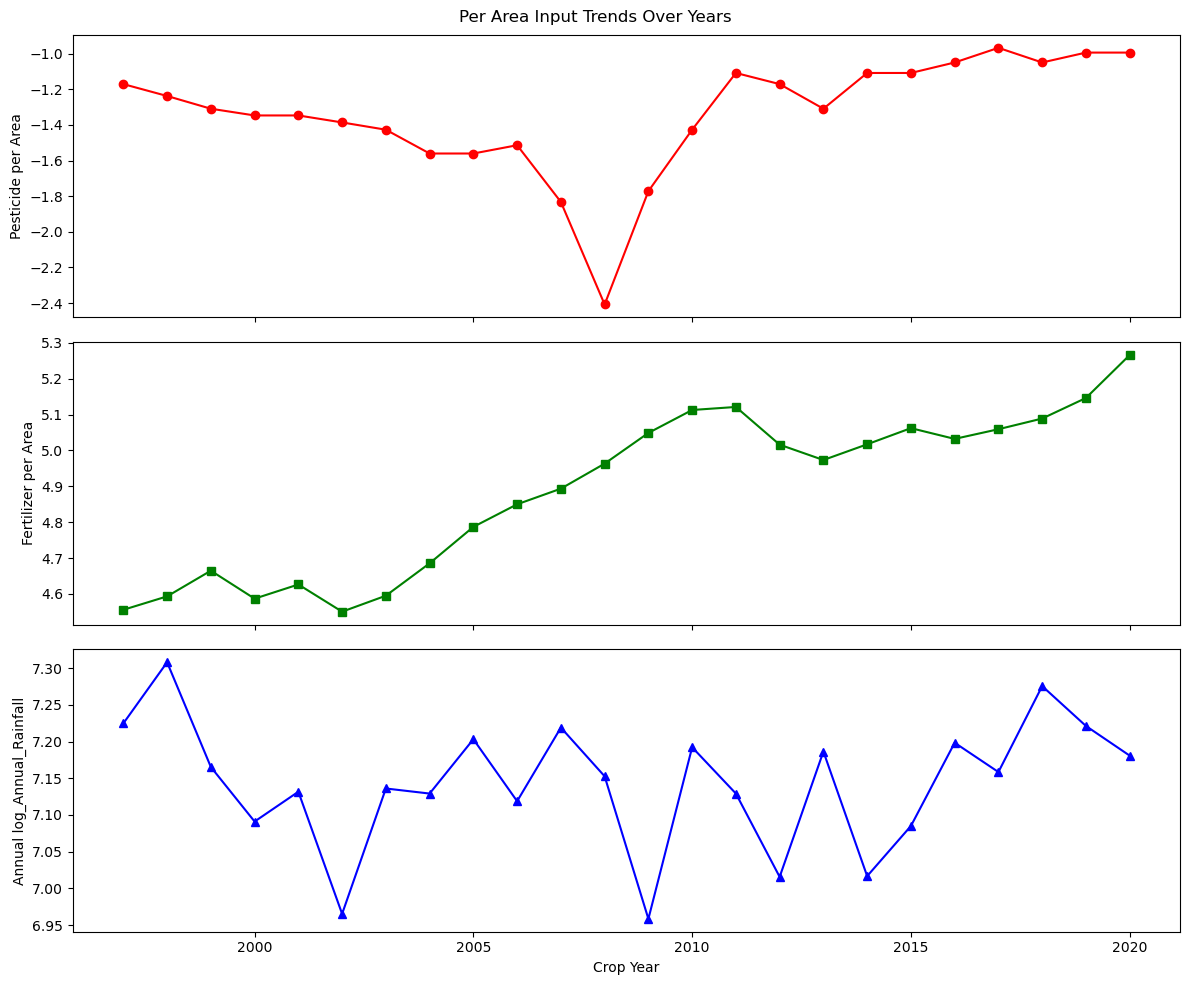

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

grouped = df.groupby('Crop_Year')[['Pesticide_per_area', 'Fertilizer_per_area', 'log_Annual_Rainfall']].mean()

axes[0].plot(grouped.index, grouped['Pesticide_per_area'], marker='o', color='r')
axes[0].set_ylabel('Pesticide per Area')

axes[1].plot(grouped.index, grouped['Fertilizer_per_area'], marker='s', color='g')
axes[1].set_ylabel('Fertilizer per Area')

axes[2].plot(grouped.index, grouped['log_Annual_Rainfall'], marker='^', color='b')
axes[2].set_ylabel('Annual log_Annual_Rainfall')
axes[2].set_xlabel('Crop Year')

fig.suptitle('Per Area Input Trends Over Years')
plt.tight_layout()
plt.show()

In [10]:
cat_cols_idx=[0,1,2,3]
cat_col_names = df.columns[cat_cols_idx]

print(cat_col_names)

Index(['Crop', 'Crop_Year', 'Season', 'State'], dtype='object')


In [11]:
y = df[output_label].values.reshape(-1,) # output feature
X = df.drop([output_label], axis=1) # inputs

## Spliting Data

In [12]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Print the shapes of training and test sets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training target shape:", y_train.shape)

Training data shape: (15661, 7)
Test data shape: (3916, 7)
Training target shape: (15661,)


## Model Training using Optuna for hyper parameter tuning

In [13]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
                "iterations": 1200,
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                "depth": trial.suggest_int("depth", 4, 10),
                "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                "boosting_type": "Ordered",
            }


    model = CatBoostRegressor(**params, cat_features=cat_cols_idx, silent=True)
    score=cross_val_score(model, X_train, y_train, cv=3, scoring="r2").mean()
    return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print(f'Best R2:, {study.best_value:.4f}')


/home/shiwang/anaconda3/envs/TensorFlow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-02 13:15:56,708] A new study created in memory with name: no-name-2e086629-3984-4efd-ab39-83dd2259e9b1
[I 2025-07-02 13:16:15,452] Trial 0 finished with value: 0.8915138965131749 and parameters: {'learning_rate': 0.02322657603739839, 'depth': 8, 'subsample': 0.1631435318186652, 'colsample_bylevel': 0.2897383716975655, 'min_data_in_leaf': 84}. Best is trial 0 with value: 0.8915138965131749.
[I 2025-07-02 13:16:35,486] Trial 1 finished with value: 0.8867388993886474 and parameters: {'learning_rate': 0.015178694655143462, 'depth': 9, 'subsample': 0.7359847533510789, 'colsample_bylevel': 0.20016152472334647, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.8915138965131749.
[I 2025-07-02 13:16:51,946] Tr

Best hyperparameters: {'learning_rate': 0.09632181882526657, 'depth': 8, 'subsample': 0.4183367809774923, 'colsample_bylevel': 0.5977136645108068, 'min_data_in_leaf': 37}
Best R2:, 0.9245


In [14]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances

plot_optimization_history(study).show()

In [15]:
plot_parallel_coordinate(study).show()

In [16]:
plot_param_importances(study).show()

### Model for best parameters

In [17]:
best_params = study.best_params
model = CatBoostRegressor(boosting_type='Ordered', **best_params, cat_features=cat_cols_idx, silent=True)
model.fit(X_train, y_train)
model.save_model("model.cbm")
y_pred = model.predict(X_test)

In [18]:
print(X_test.columns)

Index(['Crop', 'Crop_Year', 'Season', 'State', 'Fertilizer_per_area',
       'Pesticide_per_area', 'log_Annual_Rainfall'],
      dtype='object')


## Prediciton Metrices

In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error

# Undo the log transformation
y_pred_orig = np.exp(y_pred)
y_test_orig = np.exp(y_test)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
medae = median_absolute_error(y_test_orig, y_pred_orig)
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

# Adjusted R²
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print("Evaluation Metrics (Original Scale):")
print(f"Mean Absolute Error : {mae:.4f}")
print(f"Median Absolute Error : {medae:.4f}")
print(f"Median Absolute Percentage Error : {mape:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared (adj R²): {adjusted_r2:.4f}")


Evaluation Metrics (Original Scale):
Mean Absolute Error : 16.7743
Median Absolute Error : 0.1770
Median Absolute Percentage Error : 0.3099
R-squared (R²): 0.9553
Adjusted R-squared (adj R²): 0.9552


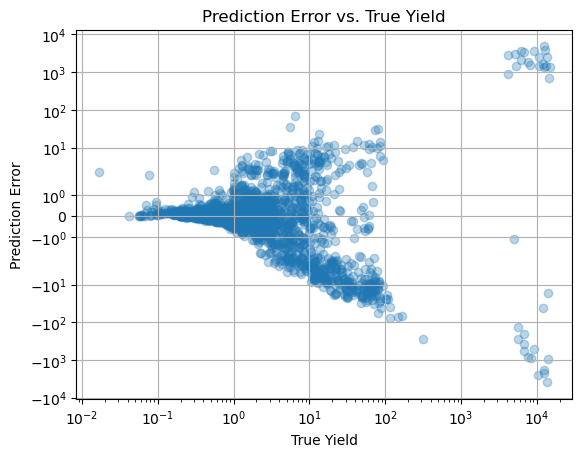

In [20]:
import matplotlib.pyplot as plt

errors = y_pred_orig - y_test_orig
plt.scatter(y_test_orig, errors, alpha=0.3)
plt.xlabel("True Yield")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs. True Yield")
plt.yscale("symlog")  # better view of wide error range
plt.xscale("log")     # better view of wide target range
plt.grid(True)
plt.show()


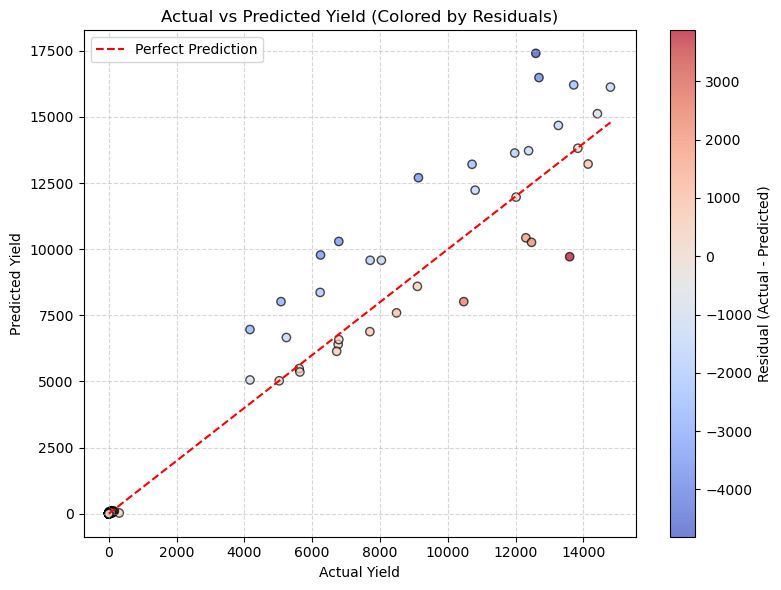

In [21]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test_orig - y_pred_orig

plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test_orig, y_pred_orig, c=residuals, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.plot([min(y_test_orig), max(y_test_orig)],[min(y_test_orig), max(y_test_orig)], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield (Colored by Residuals)')
plt.colorbar(scatter, label='Residual (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Testing Predicitons

In [22]:
def predict_new_data(features):
    # Convert the input dictionary to a pandas DataFrame (match the structure of X)
    input_data = pd.DataFrame(features)  # Single row DataFrame
    
    # Make prediction using the trained model
    prediction = model.predict(input_data)
    
    return prediction

In [44]:
random_idx = np.random.randint(0, len(X_test))

X_sample = X_test.iloc[[random_idx]]
y_actual_log = y_test[random_idx]
y_actual = np.exp(y_actual_log)


str_cols = X_sample.select_dtypes(include='object').columns
X_sample.loc[:, str_cols] = X_sample[str_cols].apply(lambda col: col.str.strip())


y_pred_log = model.predict(X_sample)
y_pred = np.exp(y_pred_log)

print(f"Actual Yield: {y_actual:.8f}")
print(f"Predicted Yield: {y_pred[0]:.2f}")
print(f"Absolute Error: {abs(y_pred[0] - y_actual):.2f}")

Actual Yield: 14.95882353
Predicted Yield: 14.43
Absolute Error: 0.53


## Shap Plots

In [24]:
import shap
import matplotlib.pyplot as plt

# SHAP explainer
shap.initjs()


explainer=shap.Explainer(model)
shap_values=explainer(X)

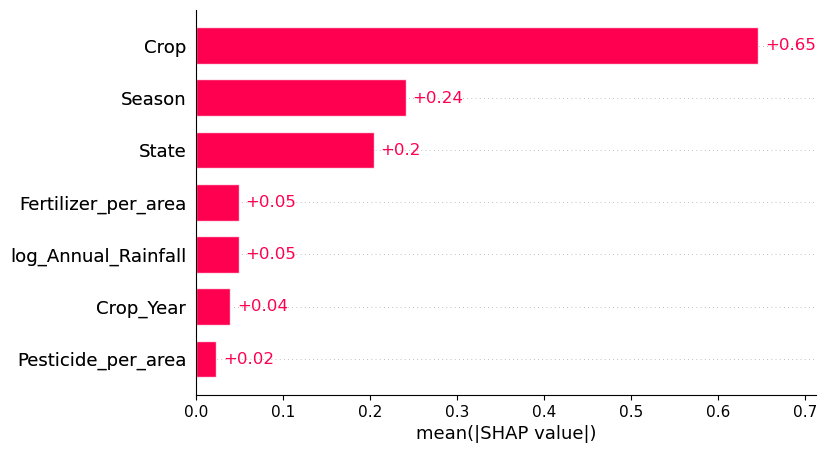

In [25]:
plt.figure(figsize=(12, 8))
shap.plots.bar(shap_values)

389
Crop                      Tobacco
Crop_Year                    1997
Season                 Whole Year
State                       Assam
Fertilizer_per_area      4.555665
Pesticide_per_area       -1.17118
log_Annual_Rainfall      7.626278
Name: 24, dtype: object


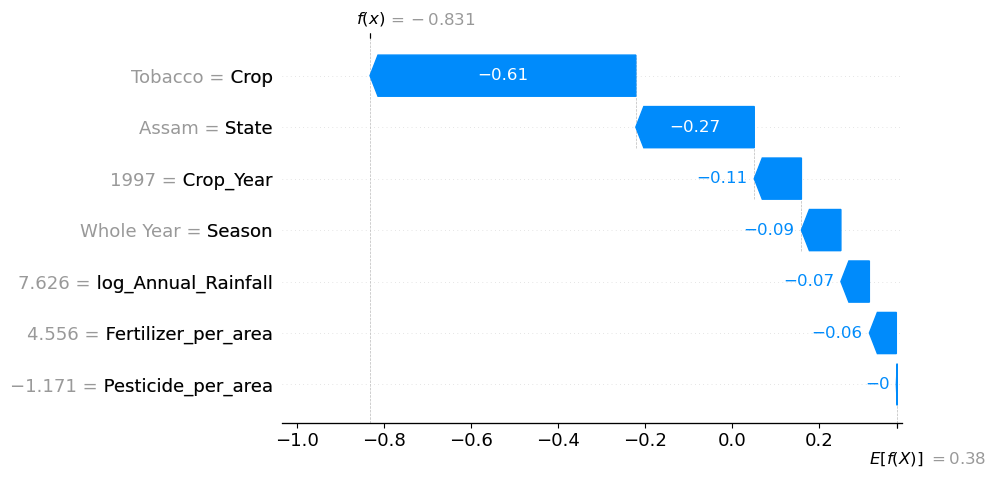

In [26]:
random_idx = np.random.randint(0, X.shape[0])

print(random_idx)
print(X.iloc[random_idx])

shap.plots.waterfall(shap_values[random_idx])
